In [106]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
import alphas, costs, model

In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [97]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("14-weeks-chiangmai.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

$$\Omega\,(w_{i}\cdot Case_{i}) = \sum_{i=0}^{n} w_{i} Case_{i}$$

$$Seasonal\,Part =1 +\,c^2 + \,\sin(\dfrac{\pi}{26}\,(x - k))$$

$$Temperature\,Part = \sum_{i=0}^{9} w_{i} Temp_{i}$$

$$Rainfall\,Part = \beta_{Rainfall} (R) + c$$

$$Humidity\,Part = \beta_{Humidity} (H) + c$$

$$Case_{\,t+1} = \Omega\,(w\cdot x) \,\times\,Seasonal\,Part \,\times\,Temperature\,Part \,\times\,Rainfall\,Part  \,\times\,Humidity\,Part$$ 

see whether which seasonality model gives a better result

## Poisson for cost function
- represents how many sigma is it away from mean

### def get_alphas(LAG, train, constant)
function takes in amount of LAG for training, data to train, and starting point for constant
- the function returns set of alphas

each lag yields different accuracy, so it'd be best to see whether which lag gives the best fit with the real plot

accumulated costs for 26 lag for 16 weeks ahead takes up to 35min 18s

In [5]:
%%time
# all_26 = alphas.get_alphas(26,all_dengues_train)
cm_26 = alphas.get_alphas(26,cm_dengues_train)
# cm_52 = alphas.get_alphas(52,cm_dengues_train)7
# cm_78 = alphas.get_alphas(78,cm_dengues_train)
# cr_26 = alphas.get_alphas(26,cr_dengues_train)

CPU times: user 52min 13s, sys: 14.5 s, total: 52min 27s
Wall time: 53min 16s


In [14]:
cm_26.x

array([  6.49449041e-01,  -5.78203433e-09,  -7.65191141e-09,
        -5.54996757e-09,  -5.22802065e-09,  -7.20315375e-09,
        -1.50623385e-08,  -7.30523211e-09,  -5.81808115e-09,
        -1.59275580e-08,  -2.78562559e-08,  -2.56935169e-08,
        -3.44347331e-08,   1.39206973e-07,   7.10788802e-02,
        -4.16707175e-07,  -3.58686498e-07,  -5.43876179e-07,
         9.67994192e-02,   1.59664830e-01,  -2.13872978e-06,
        -5.54658889e-07,  -1.33777980e-07,  -3.04532977e-08,
        -6.02759551e-08,  -1.40581707e-07,   7.44264376e-01,
        -2.88676959e-07,   2.12438461e+01])

In [660]:
all_26.x

array([  6.45928872e+00,  -2.81063115e-04,   1.54365360e-02,
        -9.30190436e-03,  -2.61540958e-02,   7.07514435e-03,
        -3.08410385e-03,   1.71667068e-02,  -6.64159216e-03,
         8.62045317e-03,   5.32562563e-03,  -1.23359431e-02,
         3.89337369e-03,  -3.35098785e-02,   6.83985201e-02,
        -4.81220453e-02,   1.56970184e-02,  -1.12371100e-02,
         2.72105526e-02,   1.72681758e-02,  -2.04506612e-02,
        -1.98536403e-03,  -3.70395872e-02,  -1.84335763e-03,
         2.36716668e-02,  -1.60758744e-04,   2.11614536e-01,
         4.06746722e+00,   1.97940382e+01])

In [8]:
cm_26.x

array([  5.48087259e-01,  -2.63662369e-02,   4.16213670e-04,
         1.74701975e-02,   1.46039067e-02,  -3.34046621e-02,
        -1.04234917e-03,   2.07497812e-02,   1.37911979e-02,
        -3.97391629e-03,  -9.07976503e-04,   1.36506804e-02,
        -8.16158062e-02,   8.99601814e-02,   3.34004754e-03,
        -3.41328541e-02,   3.66888247e-02,  -7.28057028e-02,
         5.56451602e-02,   3.13569089e-02,   1.59127299e-02,
         7.86683047e-02,  -4.24985800e-02,  -3.49621527e-02,
         3.03665765e-02,  -2.16616641e-02,   6.44252075e-01,
         7.82812701e-01,   2.01258911e+01])

In [100]:
def plot_prediction(LAG, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, first_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction)
        for i in range(weeks_ahead):
            week_to_predict = first_week_to_predict + i
            cur_prediction = model.guess(ws, week_to_predict, prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,12
        predictions = []
        for start_week in range(len(real)-(LAG-1)):
            first_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:first_week_to_predict]
            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                first_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
#     return all_predictions

    ## plot all predictions
    plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions)
        
#         title = "%s's Dengue Prediction %d lags: %d week(s) ahead [avoid negative by squaring]"%(province,LAG,nweek)
#         start_predict_week = LAG+(nweek-1)
#         make_line(start_predict_week, real, predictions, title, "# week starting 2003","cases")
#         seperate_train_test(real,cm_dengues_train)

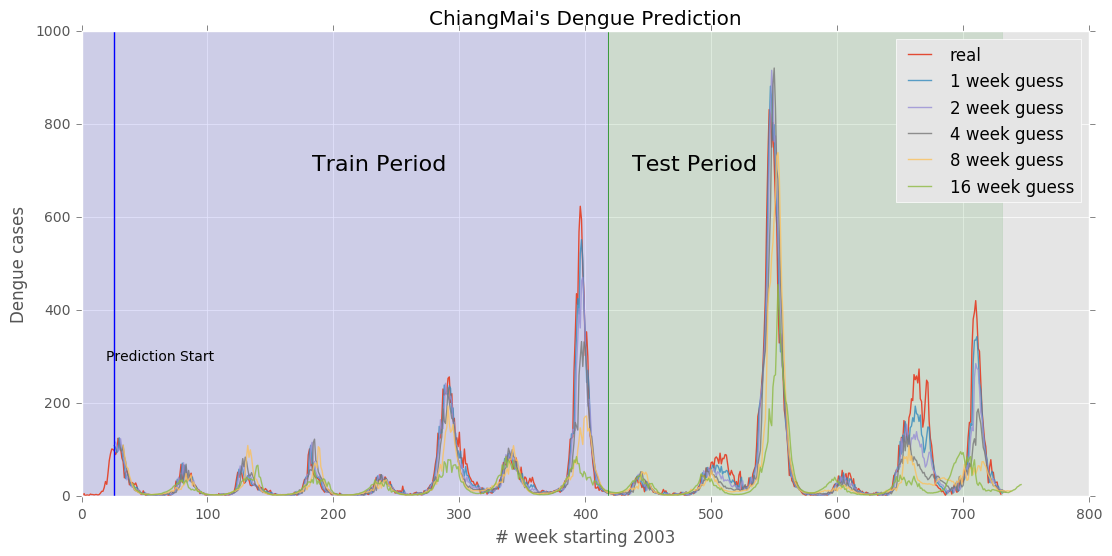

In [101]:
plot_prediction(26,cm_dengues_df.cases,cm_26.x,"ChiangMai")
# plt.xlim(len(cm_dengues_df.cases)-5,len(cm_dengues_df.cases)+5)

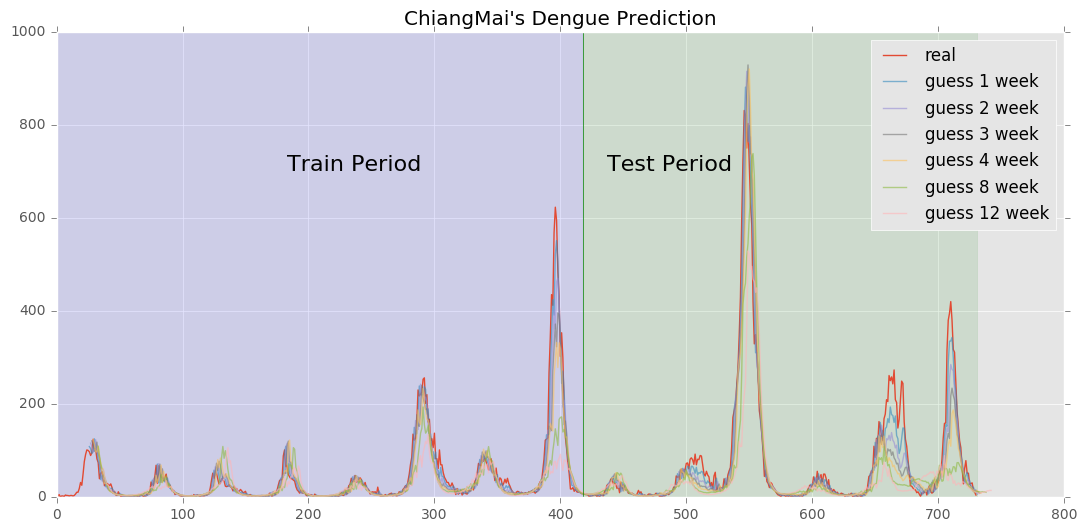

In [54]:
plt.figure(figsize=(13,6))
plt.plot(range(len(cm_dengues_df.cases)),cm_dengues_df.cases,label='real')
plt.title("ChiangMai's Dengue Prediction")
temp_weeks = [1,2,3,4,8,12]
lg = 26
for i in range(len(a)):
    nweek = temp_weeks[i]
    start_predict_week = lg+(nweek-1)
    ys = a[i]
    xs = range(start_predict_week,len(ys)+start_predict_week)
    lbl = "guess %d week"%nweek
    plt.plot(xs,ys,label=lbl,alpha=0.6)
    
seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
plt.legend()

391 417
391 417
391 417
391 417


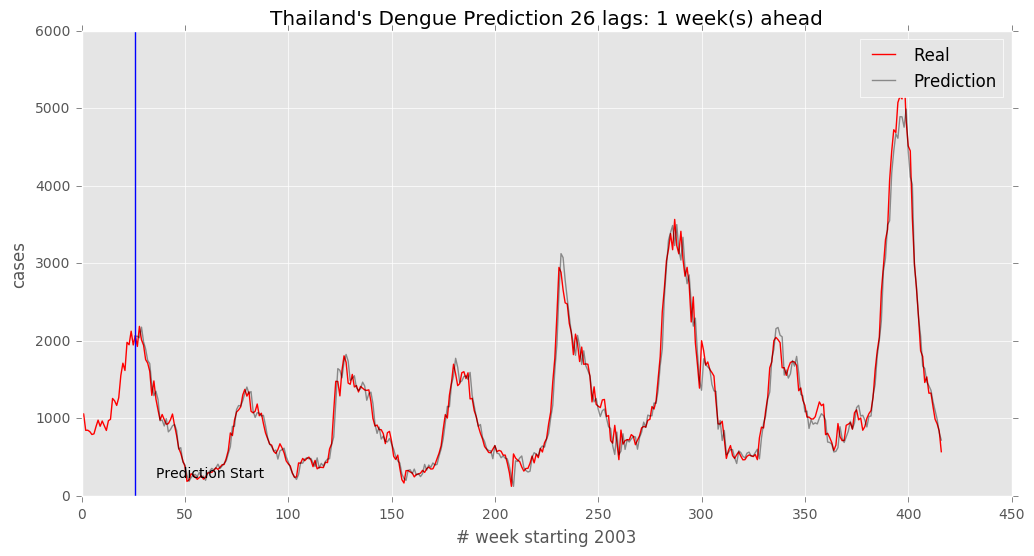

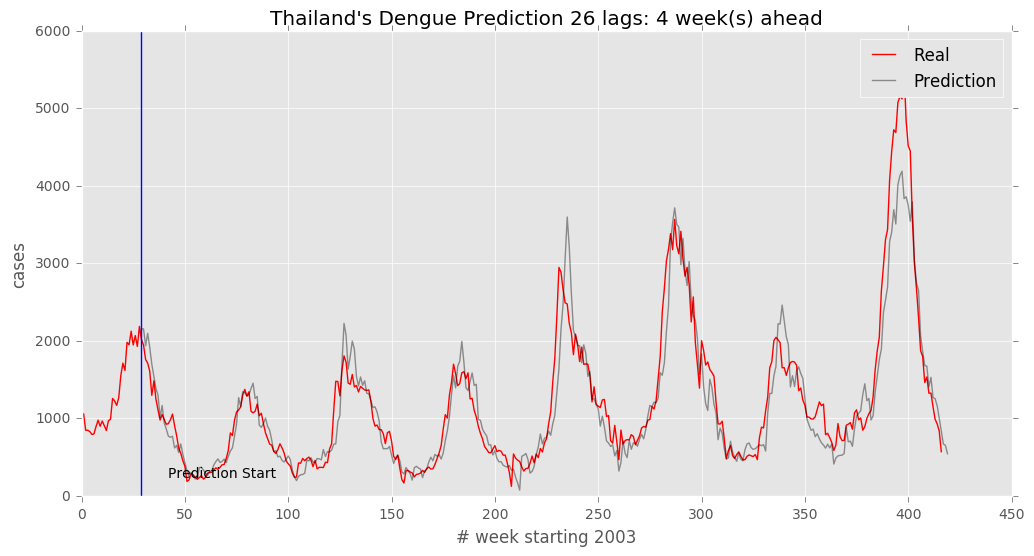

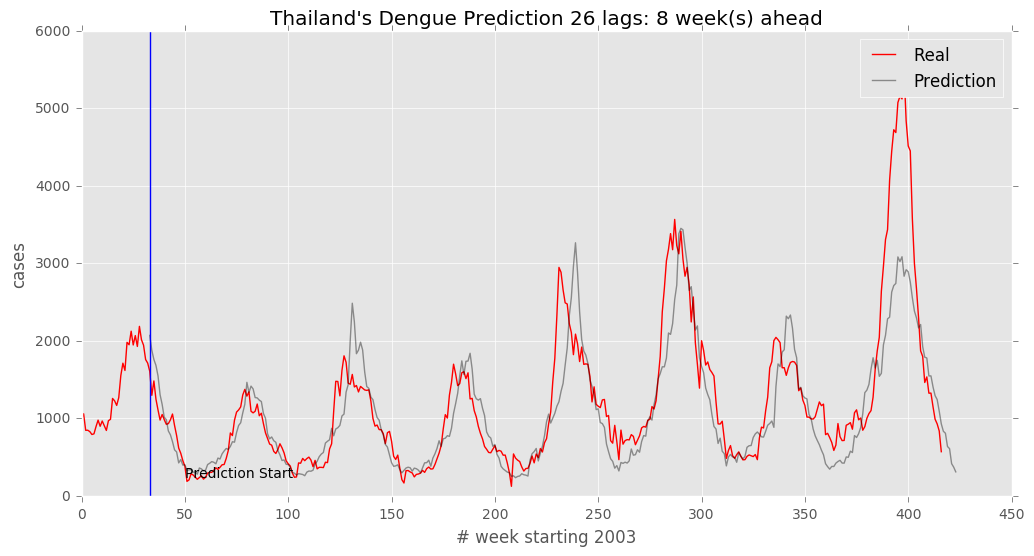

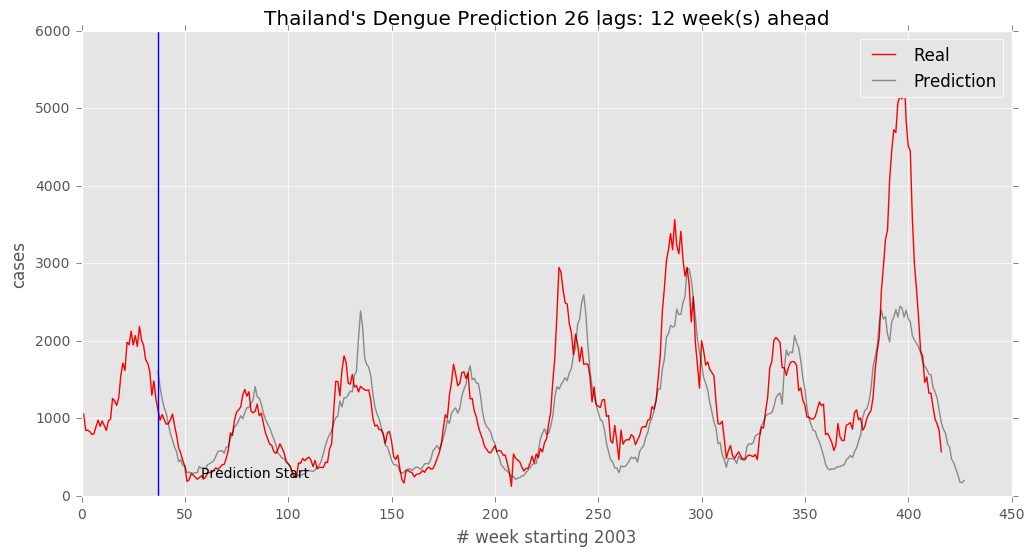

In [637]:
plot_prediction(26,all_dengues_train,all_26.x,"Thailand")

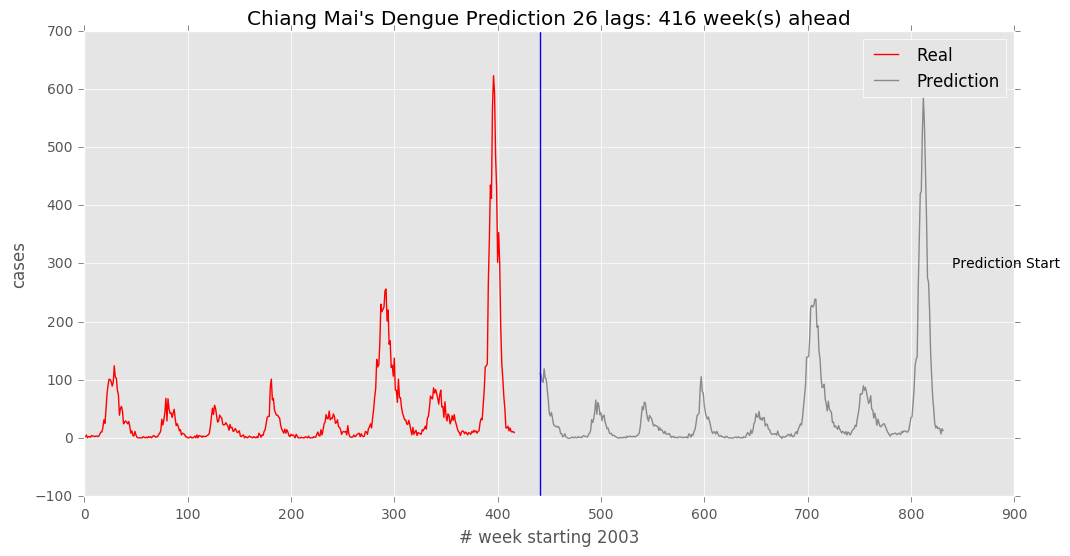

In [339]:
plot_prediction(26,cm_dengues_train,cm_26.x,"Chiang Mai")

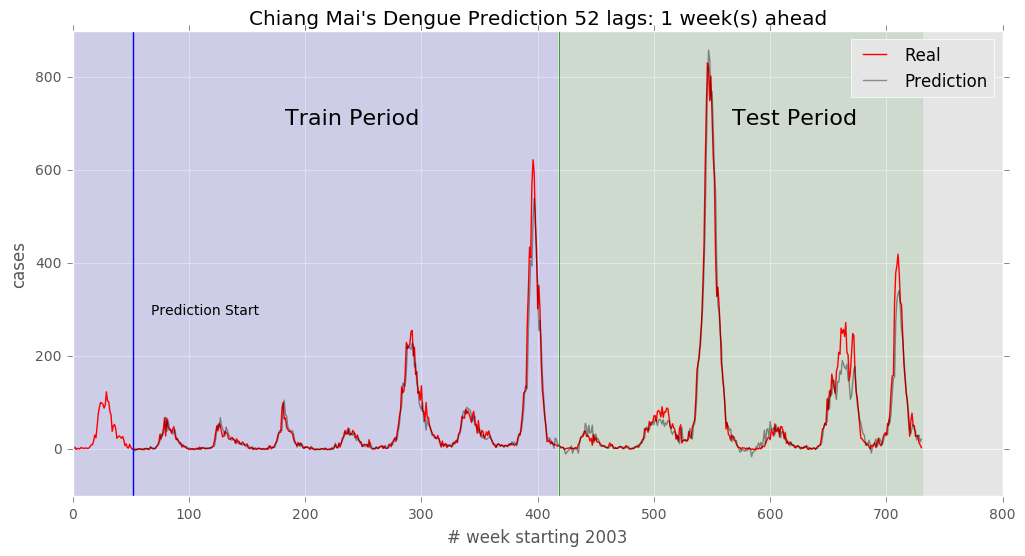

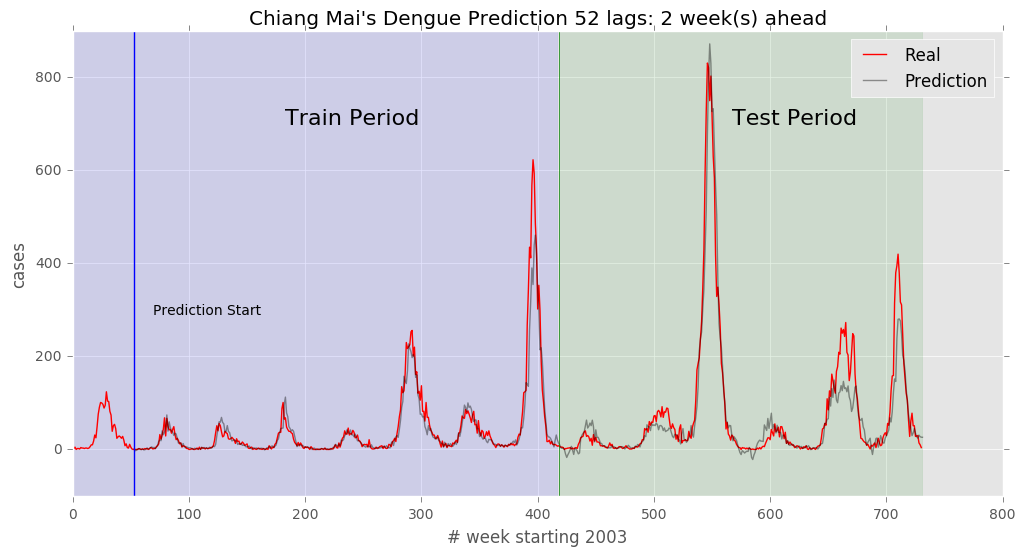

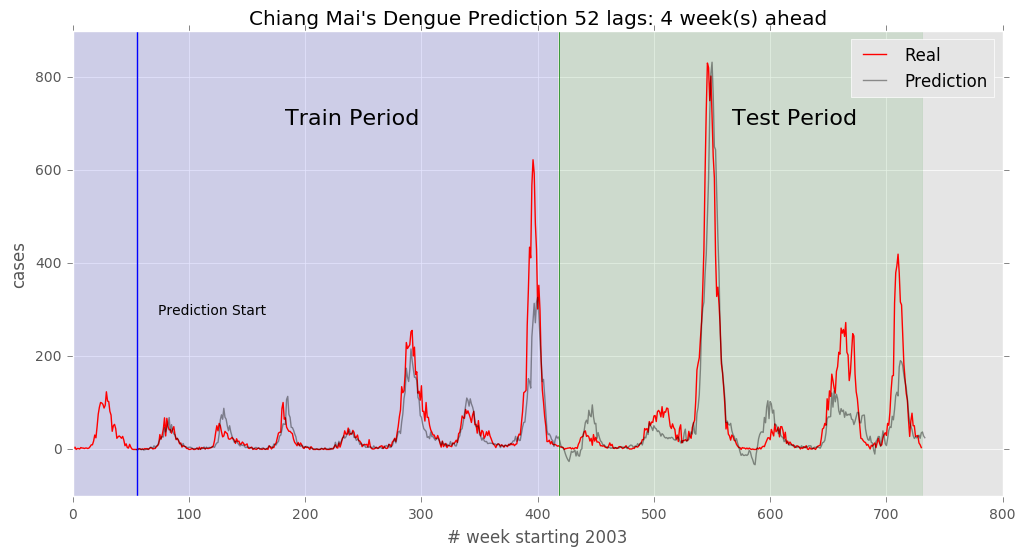

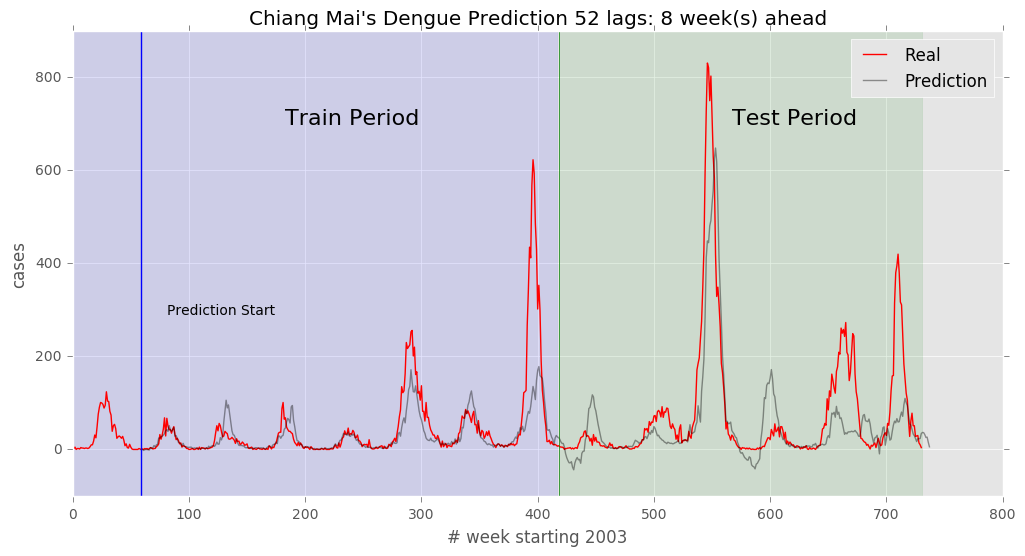

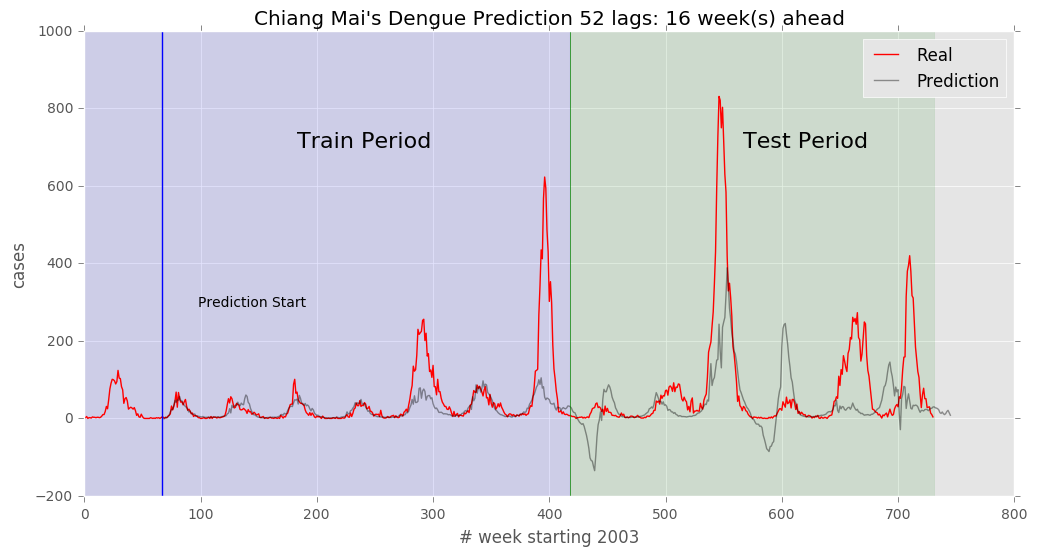

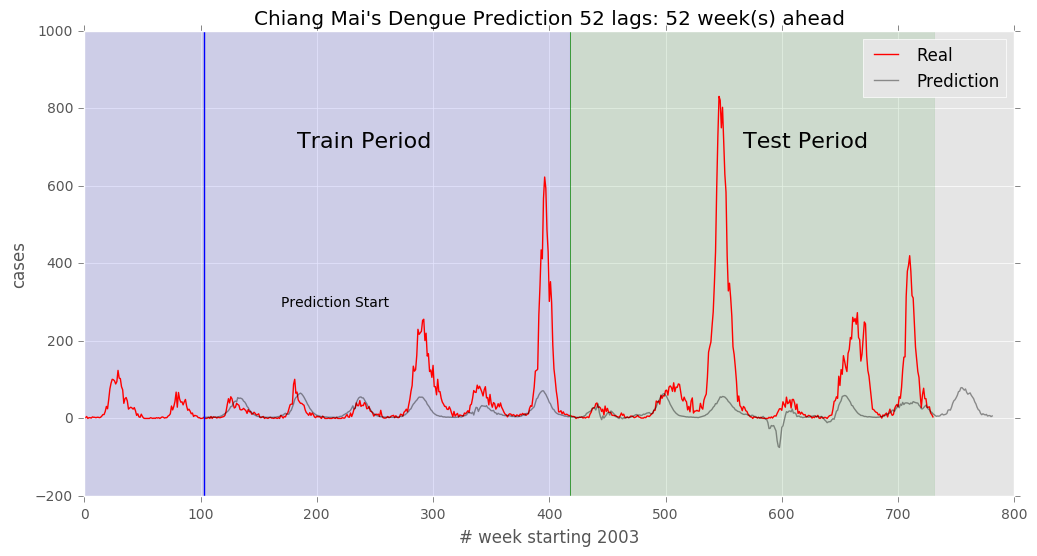

In [13]:
plot_prediction(52,cm_dengues_df.cases,cm_52.x,"Chiang Mai")

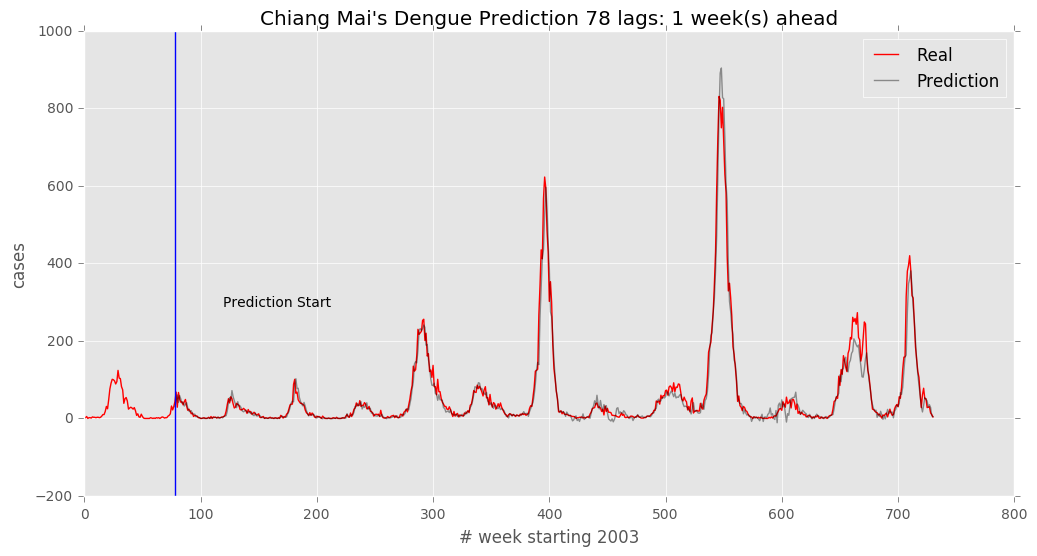

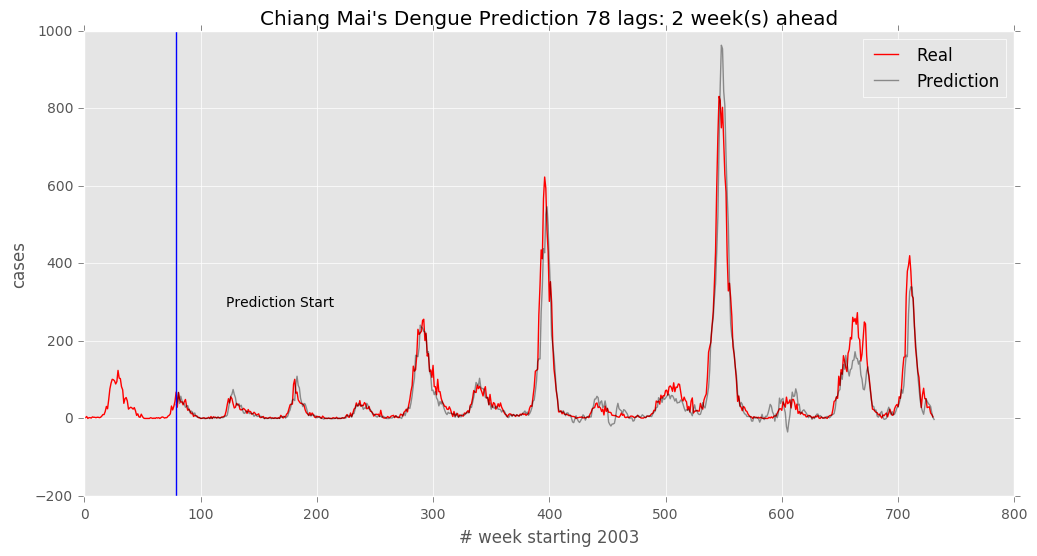

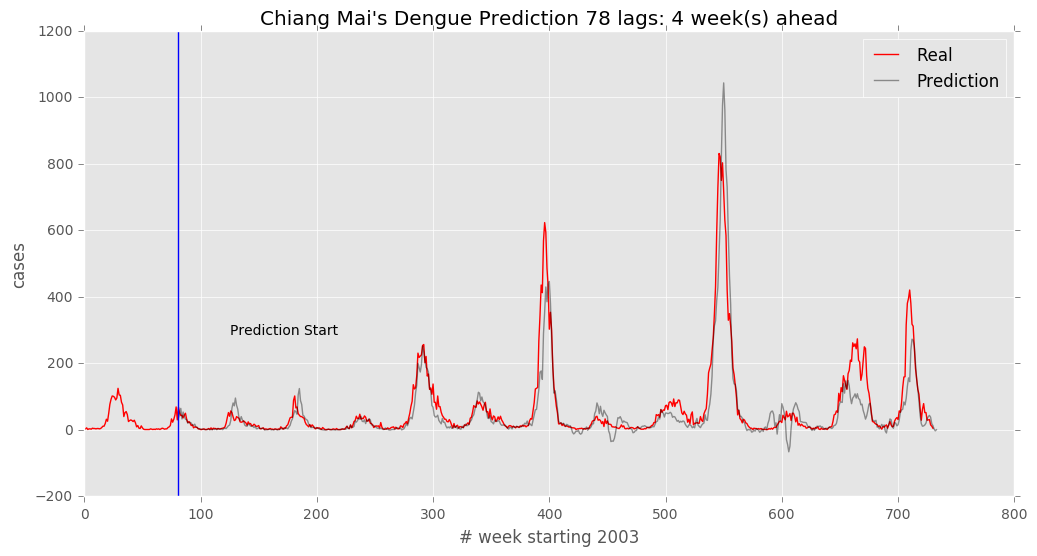

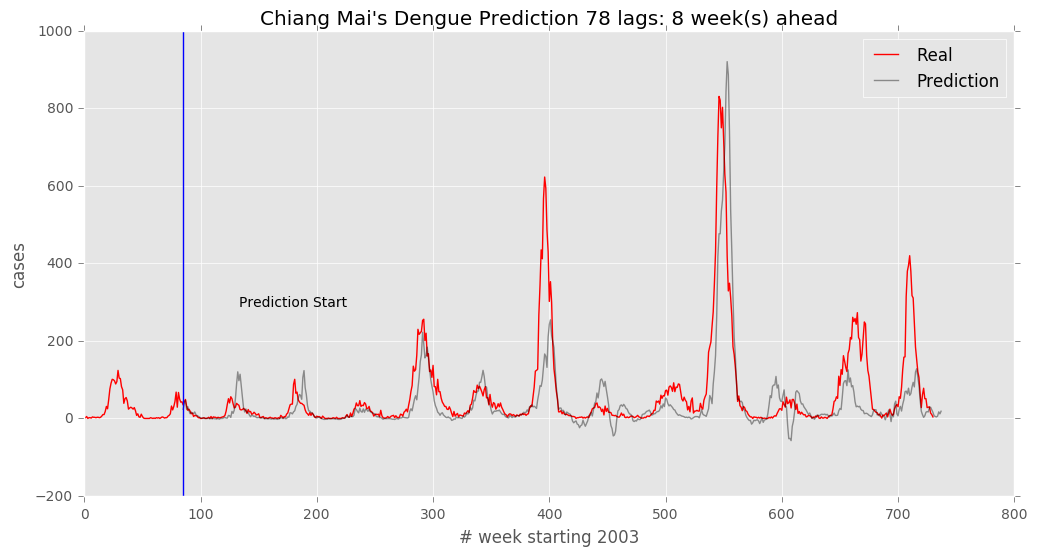

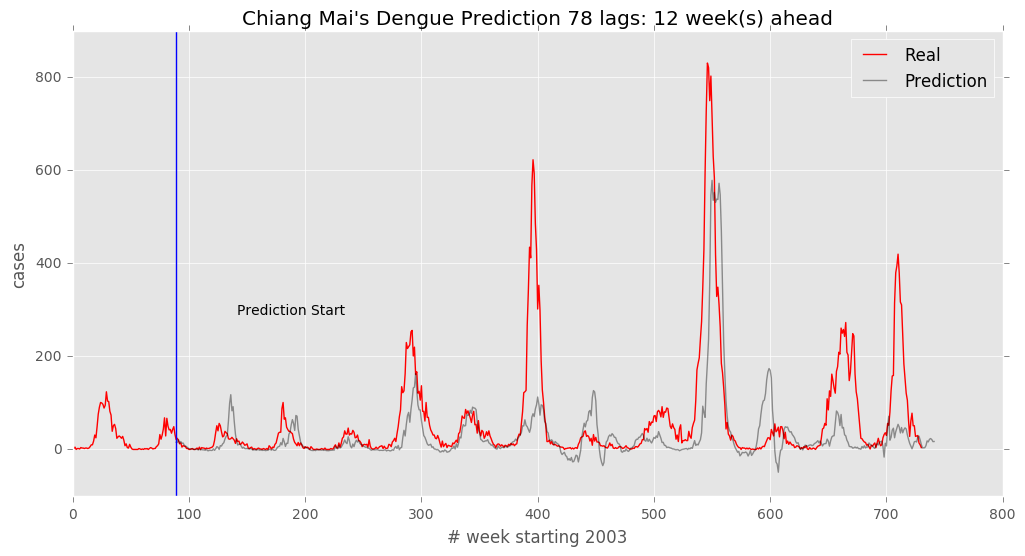

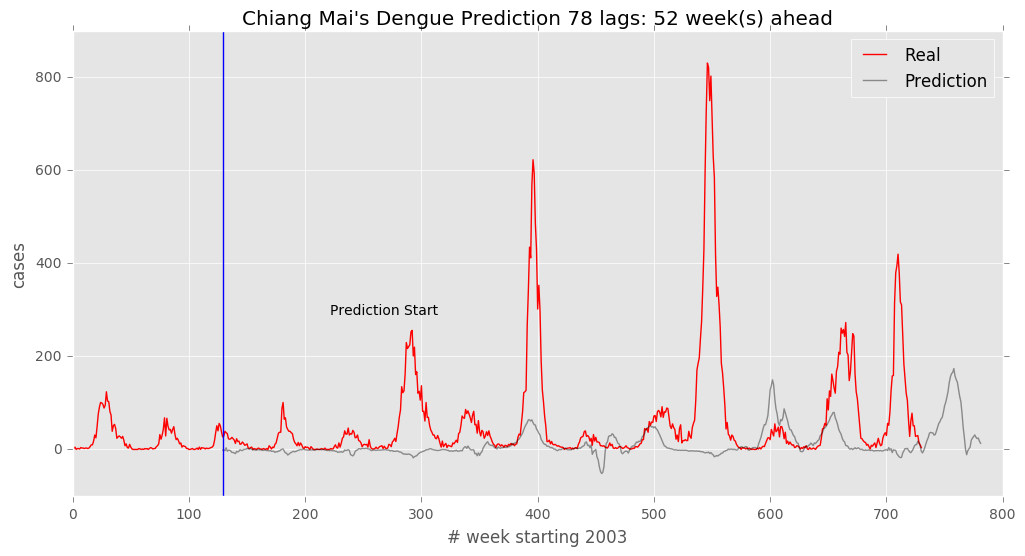

In [233]:
plot_prediction(78,cm_dengues_df.cases,cm_78.x,"Chiang Mai")

In [20]:
a = np.array([-1,-3,-2,-3,-1])
np.absolute?

In [19]:
np.abs?

In [102]:
minimize?

In [108]:
from multiprocessing import Process

def func1():
    print 'func1: starting'
    for i in xrange(10000000): pass
    print 'func1: finishing'

def func2():
    print 'func2: starting'
    for i in xrange(10000000): pass
    print 'func2: finishing'

if __name__ == '__main__':
    p1 = Process(target=func1)
    p1.start()
    p2 = Process(target=func2)
    p2.start()
#     p1.join()
#     p2.join()

func2: starting
func1: starting
func2: finishing
func1: finishing
